# Image Preprocessing

* ImageDataGenerator.[flow_from_directory](https://keras.io/preprocessing/image/#flow_from_directory) [(source)](https://github.com/tensorflow/tensorflow/blob/r1.1/tensorflow/contrib/keras/python/keras/preprocessing/image.py)
  * category mapping


* ImageDataGenerator
  * preprocess_input ([參考資料](https://medium.com/@sci218mike/圖片預處理使用keras-applications-的-preprocess-input-6ef0963a483e))
  * validation_split
    * needs keras >= 2.1.5 (hub default is 2.1.3)
    * pip install --keras==2.1.5
      * hub 重啟即回復原始狀態
      * 可加入 --user 安裝在用戶目錄(不建議)

In [1]:
import keras
import os
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array

print('keras:', keras.__version__)

classList = [
    'daisy', 
    'dandelion', 
    'rose', 
    'sunflower', 
    'tulip'
]

def preprocess_input(img):    
    #img = img.convert('L') # 轉灰階
    #img = img.convert('RGB')
    array = keras.applications.densenet.preprocess_input(img_to_array(img))
    return array_to_img(array)

# https://www.hksilicon.com/articles/1479155
datagen = ImageDataGenerator(
    #rescale=1./255,
    #preprocessing_function=keras.applications.densenet.preprocess_input,
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.1
)

train_generator = datagen.flow_from_directory(
    '../train',
    target_size=(224, 224),
    color_mode='rgb',
    classes=classList,
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    #seed=42,
    subset='training'
)

valid_generator = datagen.flow_from_directory(
    '../train',
    target_size=(224, 224),
    color_mode='rgb',
    classes=classList,
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    #seed=42,
    subset='validation'
)

x_train, y_train = train_generator.next()
x_test, y_test = valid_generator.next()
print('x_train', x_train.shape)
print('y_train', y_train.shape)
print('x_test', x_test.shape)
print('y_test', y_test.shape)

trainClassCount = {}
for i in range(len(train_generator.filenames)):
    dirName = os.path.dirname(train_generator.filenames[i])
    if dirName in trainClassCount:
        trainClassCount[dirName] += 1
    else:
        trainClassCount[dirName] = 1
print('\ntrain class count:')        
print(trainClassCount)

validClassCount = {}
for i in range(len(valid_generator.filenames)):
    dirName = os.path.dirname(valid_generator.filenames[i])
    if dirName in validClassCount:
        validClassCount[dirName] += 1
    else:
        validClassCount[dirName] = 1
print('\nvalid classes count:')        
print(validClassCount)

print('\nvalid_generator.filenames:')
print(valid_generator.filenames[65:70])
print('\nvalid_generator.classes:')
print(valid_generator.classes[65:70])

Using TensorFlow backend.


keras: 2.1.5
Found 3443 images belonging to 5 classes.
Found 380 images belonging to 5 classes.
x_train (32, 224, 224, 3)
y_train (32, 5)
x_test (32, 224, 224, 3)
y_test (32, 5)

train class count:
{'daisy': 603, 'dandelion': 857, 'rose': 616, 'sunflower': 571, 'tulip': 796}

valid classes count:
{'daisy': 66, 'dandelion': 95, 'rose': 68, 'sunflower': 63, 'tulip': 88}

valid_generator.filenames:
['daisy/14421389519_d5fd353eb4.jpg', 'dandelion/10043234166_e6dd915111_n.jpg', 'dandelion/10200780773_c6051a7d71_n.jpg', 'dandelion/10294487385_92a0676c7d_m.jpg', 'dandelion/10437652486_aa86c14985.jpg']

valid_generator.classes:
[0 1 1 1 1]


![img_flow_from_directory](./img/flowFromDirectory.png)

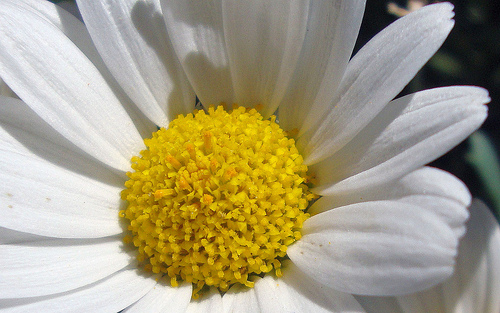

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

bgr_img = cv2.imread('../train/{}'.format(valid_generator.filenames[0]))
b,g,r = cv2.split(bgr_img)
rgb_img = cv2.merge([r,g,b])

array_to_img(rgb_img)

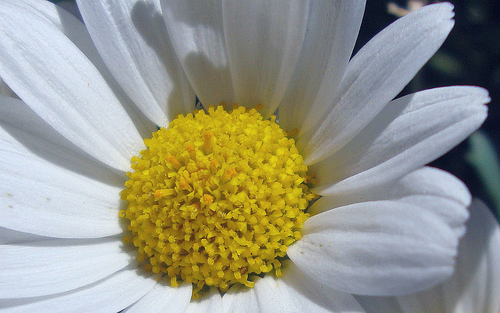

In [3]:
preprocess_input(rgb_img)

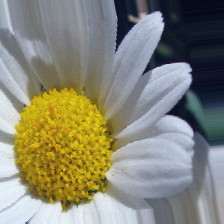

In [4]:
array_to_img(x_test[0])

# Callback - [LambdaCallback](https://keras.io/callbacks/#LambdaCallback)

* **on_epoch_begin** and **on_epoch_end** expect two positional arguments: **epoch**, **logs**
* **on_batch_begin** and **on_batch_end** expect two positional arguments: **batch**, **logs**
* **on_train_begin** and **on_train_end** expect one positional argument: **logs**

In [5]:
def _callback(epoch, logs):
    # do something here
    return

callback = keras.callbacks.LambdaCallback(on_epoch_end=lambda epoch, logs:_callback(epoch, logs))

# model_history = model.fit_generator(
#     train_generator,
#     epochs=epochs,                    
#     validation_data=valid_generator,
#     callbacks=[callback]
# )

# Save best N

* no early stop
* save_best_only = False
* take one(best?) result or ensemble

In [6]:
saveDir = './model'

def _saveCallback(epoch, logs):
    files = os.listdir(saveDir)
    files.sort()
    for file in files[10:]:
        os.remove(os.path.join(save_dir, file))
        
saveCallback = keras.callbacks.LambdaCallback(on_epoch_end=lambda epoch, logs:_saveCallback(epoch, logs))
        
checkpoint = keras.callbacks.ModelCheckpoint(
    # ./model/model.h5
    # ./model/model_{val_loss:.4f}}.h5
    './{0}/model_{1}.h5'.format(saveDir, '{val_loss:.4f}'), 
    monitor='val_loss', 
    save_best_only=False
)

# model_history = model.fit_generator(
#     train_generator,
#     epochs=epochs,                    
#     validation_data=valid_generator,
#     callbacks=[checkpoint, saveCallback]
# )

# Shuffle on each epoch

## k-fold
![img-k-fold](./img/k-fold.jpg)
___


## leave-one-out
![img-leave-one-out](./img/leave-one-out.jpg)
___


## what I did
![img-what-i-did](./img/shuffleOnEpoch.png)

> === 防雷線 ===
> 
> === 防雷線 ===
>
> === 防雷線 ===
> 
> === 防雷線 ===
>
> === 防雷線 ===
> 
> === 防雷線 ===
>
> === 防雷線 ===
> 
> === 防雷線 ===
>
> === 防雷線 ===
> 
> === 防雷線 ===


* ### pros
  * 省時，一次 training 即可看完所有 labeled images
* ### cons
  * 容易很快接近 100% accuracy
  * model 幾乎不再更新
* ### hint
  * 不要在一開始 training 時就用
  * 先做出一個最好的 model，再利用這方法提升

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

### 這絕對不是一個正規的作法
## 這絕對不是一個正規的作法
# 這絕對不是一個正規的作法
___

In [7]:
# callback
from sklearn.utils import shuffle
def _imageExchange(epoch, logs):
    #if epoch%5 != 0: return
    print('imageExchange')
    
    # 把 train set 順序弄亂
    newIdx = shuffle(range(len(train_generator.filenames)))
    train_generator.filenames = np.take(train_generator.filenames, newIdx, axis=0)
    train_generator.classes = np.take(train_generator.classes, newIdx, axis=0)
    
    # 把 valid set 的圖和 train set 交換
    for i in range(len(valid_generator.filenames)):
        # a, b = b, a
        train_generator.filenames[i], valid_generator.filenames[i] = valid_generator.filenames[i], train_generator.filenames[i]
        train_generator.classes[i], valid_generator.classes[i] = valid_generator.classes[i], train_generator.classes[i]

imageExchange = keras.callbacks.LambdaCallback(on_epoch_begin=lambda epoch, logs:_imageExchange(epoch, logs))


# # load model
# model = load_model('./model/model_0.9527.h5')

# # compile
# adam = keras.optimizers.Adam(lr=0.00008)
# model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

# # train
# model_history = model.fit_generator(
#     train_generator,
#     epochs=epochs,                    
#     validation_data=valid_generator,
#     callbacks=[checkpoint, saveCallback, imageExchange]
# )

# Reduce learning rate

* ### callback - [ReduceLROnPlateau](https://keras.io/callbacks/#ReduceLROnPlateau)

```python
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2,
                              patience=5, 
                              min_lr=0.001
)
model.fit(X_train, Y_train, callbacks=[reduce_lr])
```

* ### callback - [LearningRateScheduler](https://keras.io/callbacks/#learningratescheduler)

```python
def _lr_scheduler(epoch):
    if epoch < 5:
        return .00008
    elif epoch < 10:
        return .000016
    else:
        return .0000032
    
lr_scheduler = LearningRateScheduler(_lr_scheduler)
model.fit(X_train, Y_train, callbacks=[lr_scheduler])
```

* ### callback - [Create a callback](https://keras.io/callbacks/#create-a-callback)

```python
class myCallback(keras.callbacks.Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.test_data
        loss, acc = self.model.evaluate(x, y, verbose=0)
        print('\nTesting loss: {}, acc: {}\n'.format(loss, acc))
            
model.fit(X_train, Y_train, callbacks=[myCallback((X_test, Y_test))])
```

* ### Manual

```python
1. 100 epoch + 0.00008   learning rate + save best 5                         => 94.0%
2.  50 epoch + 0.00008   learning rate + save best 5 + shuffle on each epoch => 94.5%
3.  30 epoch + 0.000016  learning rate + save best 5 + shuffle ob each epoch => 94.5%
4.  30 epoch + 0.0000032 learning rate + save best 5 + shuffle ob each epoch => 95.0%
```

> === 再次防雷 ===
> 
> === 再次防雷 ===
> 
> === 再次防雷 ===
> 
> === 再次防雷 ===
>
> === 再次防雷 ===
>
> === 再次防雷 ===
>
> === 再次防雷 ===
>
> === 再次防雷 ===
>
> === 再次防雷 ===
>
> === 再次防雷 ===


# Conclusion

* #### **首先，你要先有一個好的 model**
  * train 到不能再 train
  * 好到不能再好
  
  
* 我提供的，是那**一點點**再提升的**可能** !!!